In [5]:
import requests

API_KEY = "dccef98218c79bd515496fdf844825cd"   # mete a tua key API-Football
BASE = "https://v3.football.api-sports.io"

def get_players_portugal():
    league_id = 94   # Primeira Liga
    season = 2023

    headers = {
        "x-apisports-key": API_KEY
    }

    players = []
    page = 1

    while True:
        url = f"{BASE}/players"
        params = {
            "league": league_id,
            "season": season,
            "page": page
        }
        r = requests.get(url, headers=headers, params=params)
        r.raise_for_status()
        data = r.json()

        # Adiciona jogadores
        players.extend(data.get("response", []))

        # paginação
        paging = data.get("paging", {})
        if paging.get("total", 1) <= page:
            break

        page += 1

    return players

players = get_players_portugal()


In [6]:
from rdflib import Graph, URIRef, Literal, RDF

grafo = Graph()

league_id = "Liga de Portugal"      # Primeira Liga
season_year = 2023    # A season que estás a usar na API-Football

for p in players:
    player = p["player"]["name"]
    age = p["player"]["age"]
    team = p["statistics"][0]["team"]["name"]
    position = p["statistics"][0]["games"]["position"]
    nationality = p["player"]["nationality"]

        # === Tipos ===
    grafo.add((Literal(player), Literal("has age"), Literal(age)))
    grafo.add((Literal(player), Literal("plays in"), Literal(team)))
    grafo.add((Literal(player), Literal("has position"), Literal(position)))
    grafo.add((Literal(team), Literal("participates in"), Literal(league_id)))
    grafo.add((Literal(player), Literal("has nationality"), Literal(nationality)))

print(grafo.__len__())
    

256


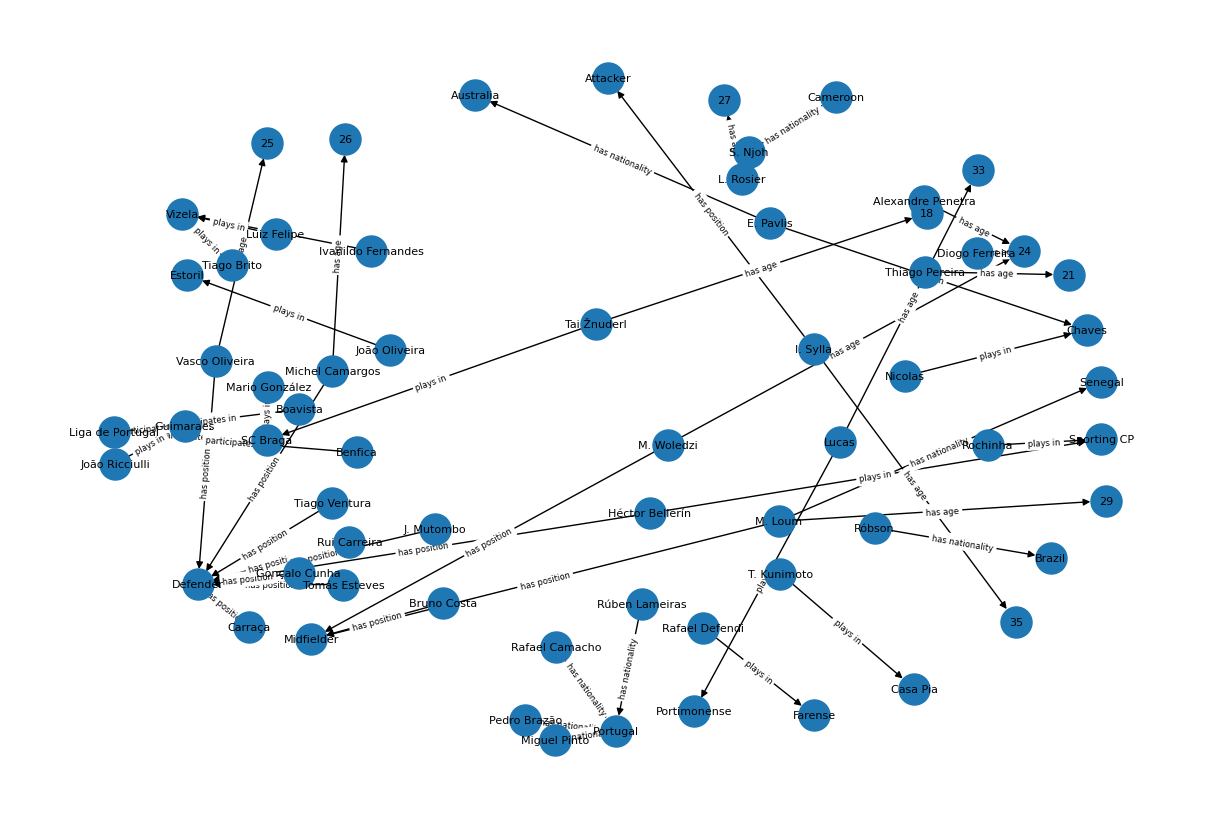

In [7]:
import networkx as nx
subgraph = list(grafo)[:50]  # 50 triplas
import matplotlib.pyplot as plt

# Converter o RDFLib Graph para NetworkX
G = nx.DiGraph()

for s, p, o in subgraph:
    G.add_edge(str(s), str(o), label=str(p))
    

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.3)
nx.draw(G, pos, with_labels=True, node_size=500, font_size=8)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(s, o): p for s, o, p in G.edges(data='label')}, font_size=6)
plt.show()

In [ ]:
import spacy
import re


nlp_en = spacy.load("en_core_web_sm")

def clean_text(text):
    text = re.sub(r"http\S+", "", text)       # URLs
    text = re.sub(r"@\w+", "", text)          # Menções
    text = re.sub(r"#\w+", "", text)          # Hashtags
    text = re.sub(r"[^A-Za-z0-9\s,.!?-]", "", text)  # Caracteres estranhos
    text = re.sub(r"\s+", " ", text)  # remove múltiplos espaços/newlines
    return text.strip()


def nlp_process(text):
    return nlp_en(text)

def entities(doc):
    entities = []

    for ent in doc.ents:
        entities.append({
            "text": ent.text,
            "type": ent.label_
        })

    return entities

def clean_tokens(doc):
    tokens = []

    for token in doc:
        if not token.is_stop and not token.is_punct:
            tokens.append(token.lemma_.lower())

    return tokens
def relations(doc):
    relations = []

    for token in doc:
        # Sujeito-VERBO-Objeto
        if token.dep_ == "ROOT" and token.pos_ == "VERB":
            subj = [c for c in token.children if c.dep_.startswith("nsubj")]
            obj = [c for c in token.children if c.dep_ in ("dobj", "pobj")]
            if subj and obj:
                rel = {
                    "subject": subj[0].text,
                    "relation": token.lemma_,
                    "object": obj[0].text
                }
                for child in obj[0].children:
                    if child.dep_ == "nummod":
                        rel["quantity"] = child.text
                relations.append(rel)

    return relations

def getnlp(text):
    cleaned = clean_text(text)
    doc = nlp_process(cleaned)

    return {
        "clean_text": cleaned,
        "tokens": clean_tokens(doc),
        "entities": entities(doc),
        "relations": relations(doc)
    }

article = """
    Cristiano Ronaldo scored 2 goals for Al Nassr yesterday in the match played in Riyadh.
    He is considered one of the best players in the world.
    """

result = getnlp(article)

print("\n==== Clean Text ====")
print(result["clean_text"])

print("\n==== Tokens ====")
print(result["tokens"])

print("\n==== Entities ====")
for e in result["entities"]:
    print(e)

print("\n==== Relations ====")
for r in result["relations"]:
    print(r)


==== Clean Text ====
Ronaldo is in al nassr

==== Tokens ====
['ronaldo', 'al', 'nassr']

==== Entities ====
{'text': 'Ronaldo', 'type': 'PERSON'}
{'text': 'al nassr', 'type': 'PERSON'}

==== Relations ====
